# NGC7753

In this notebook we present the HI observations of the galaxy ngc7753 maded with the Westerbork radio telescope. 

Authors: Angel Salazar & Quray Potosí

In [2]:
import  numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from reproject import reproject_interp
from astroquery.skyview import SkyView
from astroquery.vizier import Vizier
from spectral_cube import SpectralCube
import glob
from PIL import Image
import os
from IPython import display

Set the directory of the files

In [3]:
directory="/home/anyeldavid/Desktop/RESEARCH-INTERSHIPS/data_cubes/NGC7753/"
cube='S2349+2904_HIcube2_clean_smooth_image_5_cube_kms.fits'
mask='S2349+2904_HIcube2_clean_smooth_image_5_mask_kms.fits'

In [4]:
def read_fits_cube(path_file):
    hdul = fits.open(path_file)
    header = hdul[0].header
    data = hdul[0].data
    return header, data

In [5]:
# import data cubes 
header_cube,data_cube=read_fits_cube(directory+cube)
header_mask,data_mask=read_fits_cube(directory+mask)

In [6]:
# apply the mask
masked_data=np.where(data_mask,data_cube,0)

## Integrated Intensity (Moment 0)

In [7]:
mom0_dat = np.nansum(masked_data,axis=0)*abs(header_cube['CDELT3'])/1000

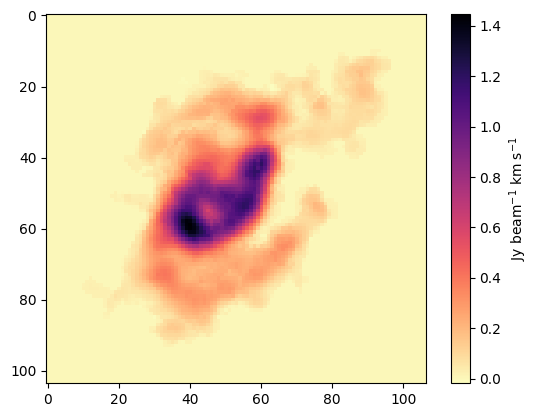

In [8]:
plt.figure()
plt.imshow(mom0_dat,cmap='magma_r')
plt.colorbar(label=r'Jy beam$^{-1}$ km s$^{-1}$')
plt.show()

In [10]:
# saving the data in a afits file
def save_data(h_1,moment,data_mom):
    wcs_new = WCS(naxis=2)
    wcs_new.wcs.cdelt = [h_1['CDELT1'], h_1['CDELT2']]
    wcs_new.wcs.ctype = [h_1['CTYPE1'], h_1['CTYPE2']]
    wcs_new.wcs.crval = [h_1['CRVAL1'], h_1['CRVAL2']]
    wcs_new.wcs.crpix = [h_1['CRPIX1'], h_1['CRPIX2']]
    header = wcs_new.to_header()        
    
# add the data and the header to an object that can be written into a file 
    hdul_new = fits.PrimaryHDU(data_mom, header=header) 
    hdul_new.writeto(directory+'{}_.fits'.format(f'ngc7753_{moment}'),overwrite=True)

In [11]:

save_data(header_cube,'mom0',mom0_dat)

In [12]:
mom0_file = "ngc7753_mom0_.fits"
header_mom0,data_mom0 = read_fits_cube(directory+mom0_file)

**Get the optical image for NGC7753, the web where we can find the galaxy image is : https://skyview.gsfc.nasa.gov/current/cgi/query.pl**  
We are going to do and overlay of the moment 0 map with on an optical image of the galaxy, for this we are going to grab an image from an online data base based on the coordinates of the HI data cube. Then we are going to grid the images to eachother to mathc the pixels and make the overlay

In [13]:
# get the central coordinate of the image
c = SkyCoord(header_mom0['CRVAL1'],header_mom0['CRVAL2'],unit='deg')
print(c.to_string('hmsdms'))

23h48m59.80617552s +29d04m15.6075168s


In [14]:
# this line grabs the image from the remote server 
#path = SkyView.get_images(position=c.to_string('hmsdms'),survey=['DSS2 Blue'],pixels=[300,300])
#hdult_opt=path[0]
#data_optical=hdul_opt[0].data
#header_optical=hdul_opt[0].header
#plt.imshow(data_optical)

**Second Option**  
We can download the optical image directly from the web source as fits file

In [43]:
optical_file='ngc7753-optical.fits'
header_optical,data_optical=read_fits_cube(directory+optical_file)


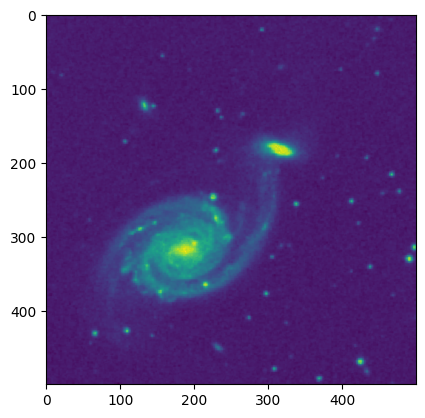

In [44]:
plt.imshow(data_optical)

**Reproject the HI image onto the same pixel grid as the optical image**

In [45]:
def calc_rms(x):
    rms = np.sqrt(np.nanmean(x**2))
    return rms

In [46]:
hi_reprojected_0,footprint = reproject_interp(hdul_mom0,header_optical)


In [47]:
hdul_mom0=fits.open(directory+mom0_file)
rms_mom0 = np.sqrt(np.nanmean(hi_reprojected_0**2))

In [48]:
print(rms_mom0)
print(np.nanmax(hi_reprojected_0))

0.4490267400501329
1.4465199708938599


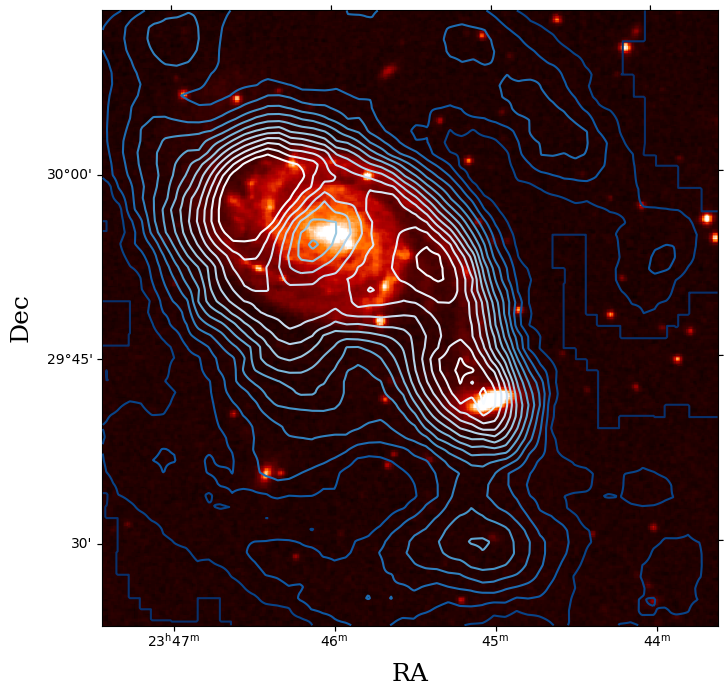

In [ ]:
fig=plt.figure(figsize=(9,8))
ax = fig.add_subplot(1,1,1, projection=WCS(header_mom0))
cb=ax.imshow(data_optical,cmap='gist_heat',vmax=np.percentile(data_optical,99.8))
ax.contour(hi_reprojected_0,levels=np.arange(0,2.8,0.2)*rms_mom0,cmap='Blues_r')
#ax.contour(hi_reprojected_0, levels=10,cmap='Blues_r')
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
#cbar=fig.colorbar(cb,ax=ax)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()